* https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/
* https://www.earthdatascience.org/courses/earth-analytics-python/spatial-data-vector-shapefiles/reproject-vector-data-in-python/
* http://darribas.org/gds15/content/labs/lab_03.html

In [30]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12,6)

In [3]:
hokusai = rio.open('D4.1/GeoTiff/hokusai_450_mpx_CF_KS_8_color_LC.tif')

In [4]:
hokusai.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028226550889045e+38,
 'width': 8529,
 'height': 4855,
 'count': 8,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",2439700,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",58],PARAMETER["latitude_of_origin",43.75],PARAMETER["central_meridian",45],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]'),
 'transform': Affine(417.84504454438274, 0.0, -1781900.1924595202,
        0.0, -436.696045830915, 1164717.2587632928)}

In [5]:
# number of bands
hokusai.count

8

<div class="alert alert-block alert-warning">
    <b>Q: How should I combine those 8 bands in one image?</b>
</div>

In [6]:
band_1 = hokusai.read(1)

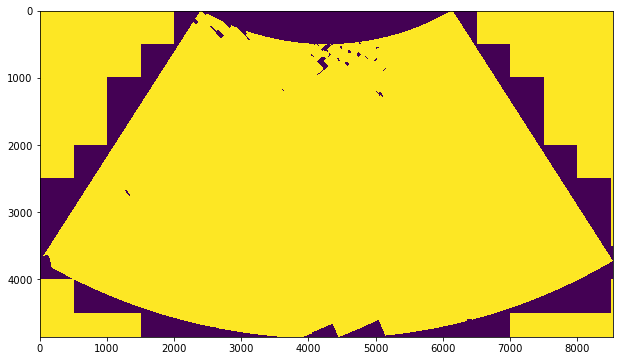

In [31]:
plt.imshow(band_1);

In [8]:
print('min: {}, max: {}'.format(band_1.ravel().min(), band_1.ravel().max()))

min: -3.4028226550889045e+38, max: 56.269229888916016


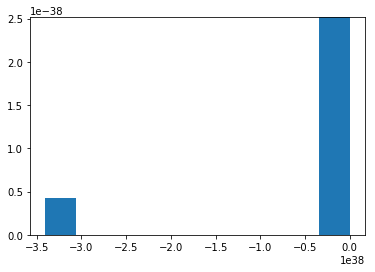

In [9]:
plt.hist(band_1.ravel(), density=True);

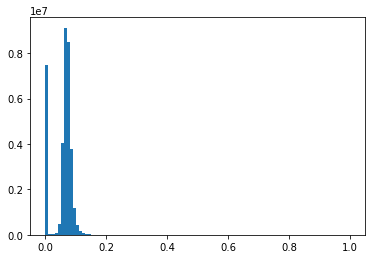

In [10]:
plt.hist(band_1.ravel(), range=(0,1), bins=100);

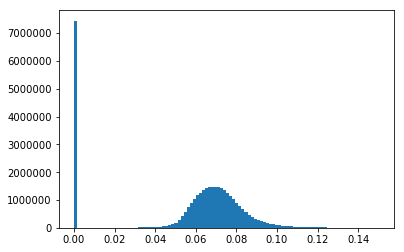

In [11]:
plt.hist(band_1.ravel(), bins=100, range=(0,0.15));

In [12]:
band_1_clean = np.clip(band_1, 0.02, 0.14)

In [13]:
np.max(band_1_clean)-np.min(band_1_clean)

0.120000005

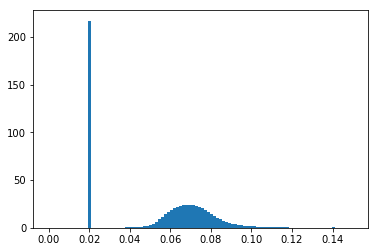

In [14]:
plt.hist(band_1_clean.ravel(), bins=100, range=(0,0.15), density=True);

In [15]:
band_1_norm = (band_1_clean - np.min(band_1_clean))/(np.max(band_1_clean)-np.min(band_1_clean))

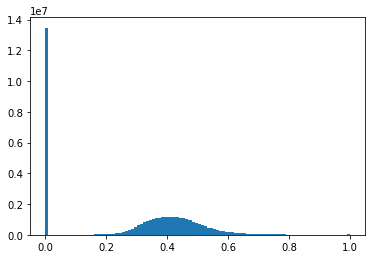

In [16]:
plt.hist(band_1_norm.ravel(), bins=100);

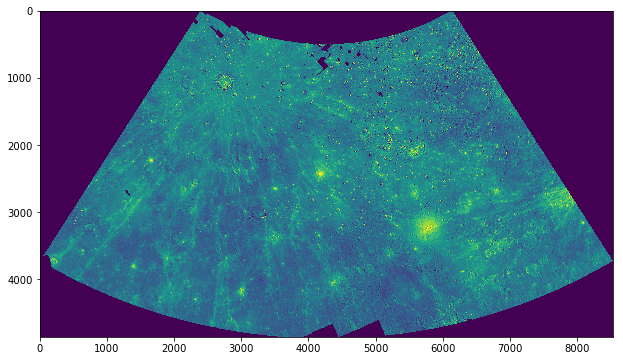

In [32]:
plt.imshow(band_1_norm)

In [18]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [19]:
dst_crs = 'EPSG:3857'

transform, width, height = calculate_default_transform(hokusai.crs, dst_crs, 
                                                       hokusai.width, hokusai.height, *hokusai.bounds)



In [20]:
print("Original dimensions: {:d},{:d}".format(hokusai.width, hokusai.height))
print("Transformed dimensions: {:d},{:d}".format(width, height))

Original dimensions: 8529,4855
Transformed dimensions: 12121,7028


In [21]:
source = band_1_norm
destination = np.zeros((height,width))

src_transform = hokusai.transform
src_crs = hokusai.crs
src_nodata = 0
dst_nodata = src_nodata
dst_transform = transform

reproject(source, destination, 
          src_transform=src_transform, src_crs=src_crs, src_nodata=src_nodata, 
          dst_transform=dst_transform, dst_crs=dst_crs, dst_nodata=dst_nodata, 
          resampling=Resampling.nearest)

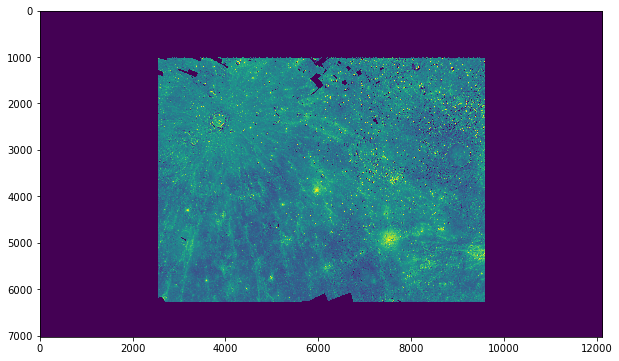

In [33]:
plt.imshow(destination)

**Instead of `EPSG:3857`, let's use the Mercator for mercury**

In [35]:
PROJ_MERCURY_MERCATOR = '+proj=merc +a=2439700 +b=2439700 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs'

dst_transform, width, height = calculate_default_transform(hokusai.crs, PROJ_MERCURY_MERCATOR, 
                                                       hokusai.width, hokusai.height, *hokusai.bounds)

destination2 = np.zeros((height,width))

reproject(source, destination2, 
          src_transform=src_transform, src_crs=src_crs, src_nodata=src_nodata, 
          dst_transform=dst_transform, dst_crs=dst_crs, dst_nodata=dst_nodata, 
          resampling=Resampling.nearest)

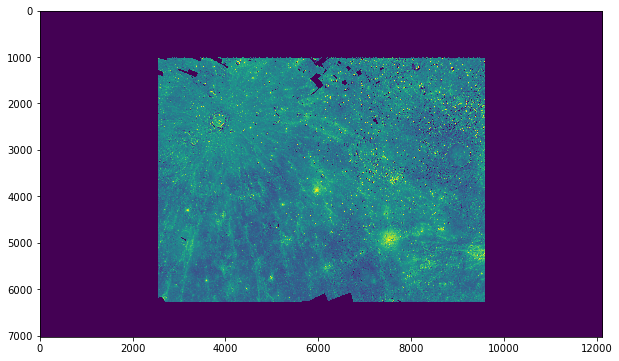

In [37]:
plt.imshow(destination2)

In [41]:
# PROJ_MERCURY_MERCATOR = '+proj=merc +a=2439700 +b=2439700 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs'

dst_meta = hokusai.meta.copy()
dst_meta.update({
    'crs': PROJ_MERCURY_MERCATOR,
    'transform': transform,
    'width': width,
    'height': height,
    'count': 1,
    'dtype': str(destination2.dtype)
})

hokusai_mercator= rio.open('D4.1/GeoTiff/hokusai_450_mpx_Band1of8-MERCATOR.tif', 
                           'w', driver='GTiff', crs=PROJ_MERCURY_MERCATOR,
                          transform=transform, width=width, height=height,
                          count=1, dtype=str(destination2.dtype), nodata=0)
hokusai_mercator.write(destination2, 1)
hokusai_mercator.close()

In [42]:
hokusai_mercator.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': 0.0,
 'width': 12121,
 'height': 7028,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknown",SPHEROID["unnamed",2439700,0],EXTENSION["PROJ4_GRIDS","@null"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Mercator_2SP"],PARAMETER["standard_parallel_1",0],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],EXTENSION["PROJ4","+proj=merc +a=2439700 +b=2439700 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs"]]'),
 'transform': Affine(545.5001425947479, 0.0, -1389764.867517323,
        0.0, -545.5001425947479, 4335823.274648666)}

## Proj4 to WKT

In [45]:
import pyproj

In [49]:
p = pyproj.Proj('+proj=merc +a=2439700 +b=2439700 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs')

In [54]:
p.crs

<CRS: +proj=merc +a=2439700 +b=2439700 +lat_ts=0.0 +lon_ ...>
Name: unknown
Ellipsoid:
- semi_major_metre: 2439700.00
- semi_minor_metre: nan
- inverse_flattening: 0.00
Area of Use:
- UNDEFINED
Prime Meridian:
- longitude: 0.0000
- unit_name: degree
- unit_conversion_factor: 0.01745329
Axis Info:
- Easting[E] (east) EPSG:9001 (metre)
- Northing[N] (north) EPSG:9001 (metre)

In [55]:
p.srs

'+proj=merc +a=2439700 +b=2439700 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs'

In [57]:
p.crs.to_wkt()

'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",2439700,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Reference meridian",0,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]]],CONVERSION["unknown",METHOD["Popular Visualisation Pseudo Mercator",ID["EPSG",1024]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]'